In [1]:
# set up
import os
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np

os.chdir("../data/")

In [2]:
# load data
parcels = geopandas.read_file('Parcels_FY19')

In [3]:
parcels.head()

,OBJECTID,Map,Block,Lot,MBL,PolyType,AddNum,Street,AddNum2,Street2,AddNum3,Street3,SublotOf,TaxParMBL,Shape_Leng,Shape_Area,geometry
0,1,19,F,1,19-F-1,PARCEL,838,BROADWAY,None,None,None,None,None,19-F-1,2133.460536,197502.465873,"MULTIPOLYGON (((759940.058 2971010.939, 759892..."
1,2,54,D,5,54-D-5,PARCEL,393,WASHINGTON ST,None,None,None,None,None,54-D-5,316.130596,2397.402540,"MULTIPOLYGON (((762784.549 2963229.330, 762760..."
2,3,85,A,14,85-A-14,PARCEL,0,ASSEMBLY ROW,None,None,None,None,None,85-A-14,9542.340855,207970.565472,"POLYGON ((769452.915 2969581.503, 769463.029 2..."
3,4,94,C,6,94-C-6,PARCEL,10,POPLAR ST,None,None,None,None,None,94-C-6,1492.376498,83911.819744,"POLYGON ((767606.618 2962997.970, 767678.158 2..."
4,5,117,A,2,117-A-2,PARCEL,0,INNER BELT RD,None,None,None,None,None,117-A-2,4249.883150,239816.278490,"MULTIPOLYGON (((771386.600 2961124.380, 771385..."


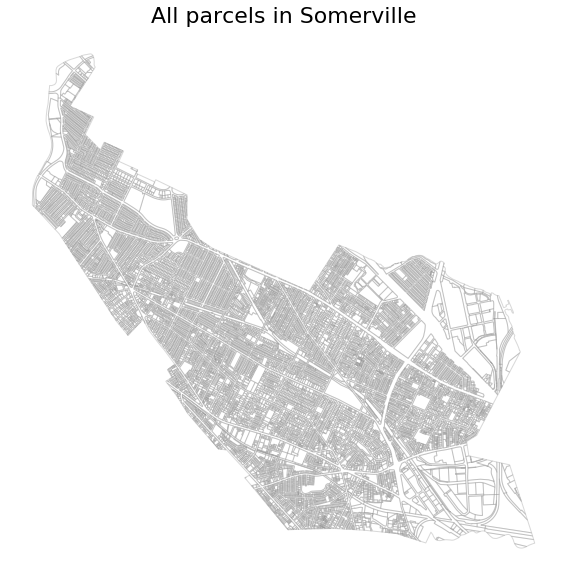

In [4]:
# parcel map
fig, ax = plt.subplots(figsize=(20,10))
parcels.plot(ax=ax, color='white', edgecolor='grey', alpha=0.3)
plt.title("All parcels in Somerville", fontsize=22)
plt.axis('off');

In [5]:
# read in labels
manual_labels = pd.read_csv('../labels/training_labels_updated_111219.csv')
additional_manual_labels = pd.read_csv('../labels/additional_training_labels_120319.csv')
labels = pd.concat([manual_labels, additional_manual_labels], axis=0)

/Users/anthonyrentsch/anaconda3/envs/somerville-parking/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [6]:
manual_labels.shape, additional_manual_labels.shape, labels.shape

((488, 9), (162, 9), (650, 12))

In [7]:
labels.head()

,ADDRESS_FOR_STREET_VIEW,ADDR_NUM,AERIAL_Driveway,FULL_STR,GSV_Driveway,MBL,aerial_addr,aerial_filename,final_label,gsv_filename,sv_addr,three_class_label
0,"5 DOUGLAS AVE, SOMERVILLE, MA",5,2.0,DOUGLAS AVE,0.0,47-G-17,NaN,5_DOUGLAS_AVE_aerial.png,0.1,5_DOUGLAS_AVE.jpg,NaN,NaN
1,"6 HILLSIDE CIR, SOMERVILLE, MA",6,1.0,HILLSIDE CIR,2.0,38-A-47,NaN,6_HILLSIDE_CIR_aerial.png,0.9,6_HILLSIDE_CIR.jpg,NaN,NaN
2,"8 BELMONT PL, SOMERVILLE, MA",8,2.0,BELMONT PL,2.0,44-A-48,NaN,8_BELMONT_PL_aerial.png,0.5,8_BELMONT_PL.jpg,NaN,NaN
3,"8 DRESDEN CIR, SOMERVILLE, MA",8,2.0,DRESDEN CIR,2.0,25-A-13,NaN,8_DRESDEN_CIR_aerial.png,0.5,8_DRESDEN_CIR.jpg,NaN,NaN
4,"8 HAWTHORNE ST, SOMERVILLE, MA",8,0.0,HAWTHORNE ST,2.0,25-D-16,NaN,8_HAWTHORNE_ST_aerial.png,0.1,8_HAWTHORNE_ST.jpg,NaN,NaN


In [8]:
labels.final_label.value_counts()

1.0    294
0.9    211
0.1     60
0.0     43
0.5     42
Name: final_label, dtype: int64

In [9]:
# join
parcel_labels = parcels.merge(labels, how='left', left_on='TaxParMBL', right_on='MBL')

In [10]:
parcel_labels.shape

(14096, 29)

In [11]:
# denote ones we have labeled
parcel_labels['label_flag'] = pd.notna(parcel_labels['final_label'])

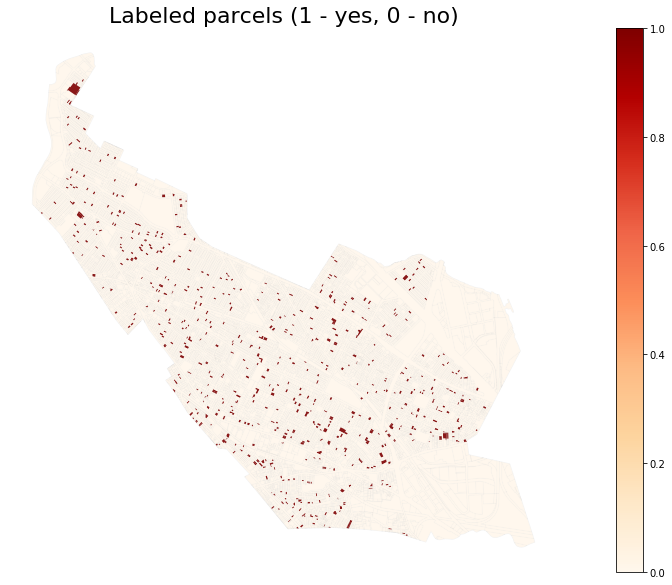

In [12]:
# map where we labeled
fig, ax = plt.subplots(figsize=(20,10))
parcel_labels.plot(ax=ax, color='white', edgecolor='grey', alpha=0.1)
parcel_labels.plot(ax=ax, column='label_flag', alpha=0.9, legend=True, cmap='OrRd')
plt.title("Labeled parcels (1 - yes, 0 - no)", fontsize=22)
plt.axis('off');

In [13]:
# map what labels were
label_mapping = {0: 'no', 0.1:'no', 0.5:'unsure', 0.9:'yes', 1:'yes', np.nan:'no label'}
parcel_labels['3_labels'] = parcel_labels['final_label'].map(label_mapping)

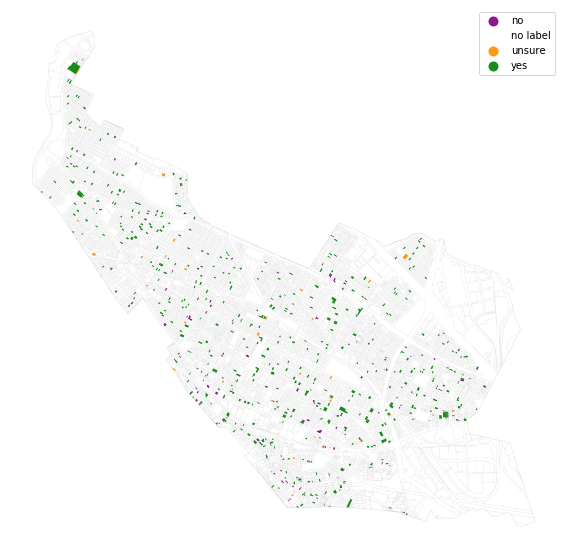

In [14]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(["purple", "white", "darkorange", "green"])
fig, ax = plt.subplots(figsize=(20,10))
parcel_labels.plot(ax=ax, color='white', edgecolor='grey', alpha=0.2)
parcel_labels.plot(ax=ax, column='3_labels', alpha=0.9, legend=True, cmap=cmap)
plt.title("", fontsize=22)
plt.axis('off');

# Load predictions

In [103]:
calibrated_preds = pd.read_csv('../data/calibrated_driveway_predictions.csv')

In [104]:
calibrated_preds.head()

,MBL,calibrated_yes_driveway
0,1-C-5,0.989813
1,1-C-6,0.989813
2,1-C-7,1.000000
3,1-C-8,0.883721
4,1-C-9,0.989813


# Aggregate by block

In [105]:
calibrated_preds['block'] = calibrated_preds['MBL'].apply(lambda x: x.split('-')[0] + x.split('-')[1])

In [106]:
block_pred_counts = calibrated_preds.groupby('block').mean()['calibrated_yes_driveway'].to_frame().reset_index()

In [107]:
block_pred_counts.columns = ['block', 'block_pred_counts']

In [108]:
calibrated_preds = calibrated_preds.merge(block_pred_counts, how='left', left_on='block', right_on='block')

In [109]:
parcel_calibrated_preds = parcels.merge(calibrated_preds, how='left', left_on='MBL', right_on='MBL')

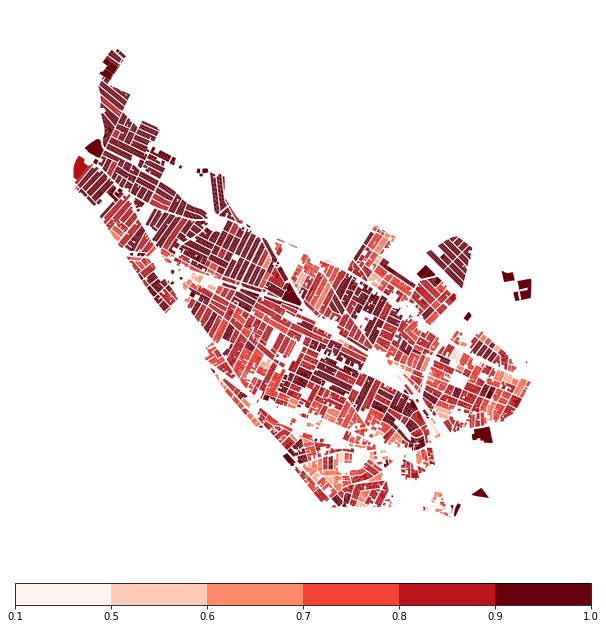

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
bins = [0.1,0.5,0.6,0.7,0.8,0.9,1]

parcel_calibrated_preds.plot(ax=ax, color='white', edgecolor='white', alpha=0.1)
#parcel_calibrated_preds.plot(ax=ax, column='block_pred_counts', cmap='Reds', alpha=0.7)
parcel_calibrated_preds[parcel_calibrated_preds['block_pred_counts'].notnull()].plot(ax=ax, 
                                                                                  column='block_pred_counts', 
                                                                                  cmap='Reds', 
                                                                                  scheme='user_defined',
                                                                                  classification_kwds={'bins':bins},
                                                                                  legend=False)
# DISCRETE
cmap = plt.cm.Reds 
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
norm = mpl.colors.BoundaryNorm(bins, cmap.N)

# create a second axes for the colorbar
ax_cm = fig.add_axes([0.3, 0.05, 0.4, 0.03]) #left bottom width height
cb = mpl.colorbar.ColorbarBase(ax_cm, cmap=cmap, norm=norm, orientation='horizontal',
    spacing='uniform', ticks=bins, boundaries=bins)



# CONTINUOUS
# # Create colorbar as a legend
# sm = plt.cm.ScalarMappable(cmap='Reds', 
#                            norm=plt.Normalize(vmin=0, vmax=parcel_calibrated_preds['block_pred_counts'].max()))
# # empty array for the data range
# sm._A = []
# # add the colorbar to the figure
# cbar = fig.colorbar(sm, shrink=0.5, orientation='horizontal', pad=0)

ax.axis('off');
#plt.savefig('../images/block_predictions_map', dpi=450);

# Add streets

In [23]:
streets = geopandas.read_file('Streets')

In [24]:
streets.head()

,OBJECTID,Street,RouteNo,FuncClass,Ownership,OneWay,HasROW,Shape_Leng,geometry
0,1,MYSTIC VALLEY PKWY,16,Urban Principal Arterial,Public,F,T,816.181222,"LINESTRING (756886.080 2977526.838, 756877.267..."
1,2,BOSTON AVE,None,Urban Minor Arterial,Public,F,T,422.297873,"LINESTRING (755917.880 2977331.082, 756234.375..."
2,3,MYSTIC VALLEY PKWY,16,Urban Principal Arterial,Public,F,T,259.022827,"LINESTRING (756073.250 2976849.000, 756108.438..."
3,4,BOSTON AVE,None,Urban Minor Arterial,Public,F,T,491.512950,"LINESTRING (756602.438 2976725.750, 756301.375..."
4,5,BOSTON AVE,None,Urban Minor Arterial,Public,F,T,56.572662,"LINESTRING (756644.864 2976688.327, 756643.250..."


In [25]:
streets['coords'] = streets['geometry'].apply(lambda x: x.representative_point().coords[:])
streets['coords'] = [coords[0] for coords in streets['coords']]
streets['x'] = streets['coords'].apply(lambda x: x[0])
streets['y'] = streets['coords'].apply(lambda x: x[1])

In [26]:
for i in pd.Series(streets['Street'].unique()).sort_values():
    print(i)

ABERDEEN RD
ACADIA PARK
ADAMS ST
ADELAIDE RD
ADRIAN ST
ALBION CT
ALBION PL
ALBION ST
ALBION TER
ALDERSEY ST
ALDRICH ST
ALEWIFE BROOK PKWY
ALFRED A LOMBARDI  WAY
ALFRED ST
ALLEN CT
ALLEN ST
ALPINE ST
ALSTON ST
AMES ST
APPLETON ST
ARLINGTON ST
ARNOLD AVE
ARNOLD CT
ARTISAN WAY
ASH AVE
ASHLAND ST
ASSEMBLY ROW
ASSEMBLY SQ DR
ATHERTON ST
AUBURN AVE
AUSTIN ST
AUTUMN ST
AVON PL
AVON ST
BAILEY RD
BAILEY ST
BANKS ST
BARTLETT ST
BARTON ST
BAY STATE AVE
BEACH AVE
BEACON PL
BEACON ST
BEACON TER
BECKWITH CIR
BEDFORD ST
BEECH ST
BELKNAP ST
BELLEVUE TER
BELMONT PL
BELMONT SQ
BELMONT ST
BELMONT TER
BENEDICT AVE
BENEDICT ST
BENTON RD
BERKELEY ST
BERWICK ST
BIGELOW ST
BILLINGHAM ST
BISHOP PL
BLAKELEY AVE
BLEACHERY CT
BOLTON ST
BONAIR ST
BOND ST
BONNER AVE
BOSTON AVE
BOSTON ST
BOW MARKET WAY
BOW ST
BOW ST PL
BOWDOIN ST
BOWERS AVE
BRADFORD AVE
BRADLEY ST
BRASTOW AVE
BRISTOL RD
BROADWAY
BROADWAY PL
BROADWAY TER
BROMFIELD RD
BROOK ST
BROWNING RD
BUCKINGHAM ST
BUENA VISTA RD
BURNHAM ST
BURNSIDE AVE
CADY AVE
C

In [27]:
major = ['BROADWAY', 'HIGHLAND AVE', 'POWDER HOUSE BLVD', 'SUMMER ST', 'WASHINGTON ST']
major_streets = streets[streets['Street'].isin(major)]
major_streets = major_streets.groupby('Street').mean()[['x','y']].reset_index()
major_streets['coords'] = major_streets[['x','y']].apply(tuple, axis=1)

In [28]:
major_streets

,Street,x,y,coords
0,BROADWAY,763561.655825,2.969355e+06,"(763561.6558247947, 2969354.6130962535)"
1,HIGHLAND AVE,761664.450725,2.967789e+06,"(761664.4507248453, 2967788.667247756)"
2,POWDER HOUSE BLVD,757727.835077,2.972679e+06,"(757727.8350765314, 2972679.252856067)"
3,SUMMER ST,761845.184095,2.966651e+06,"(761845.1840953425, 2966651.1893501948)"
4,WASHINGTON ST,766131.699192,2.963777e+06,"(766131.6991920472, 2963777.067631718)"


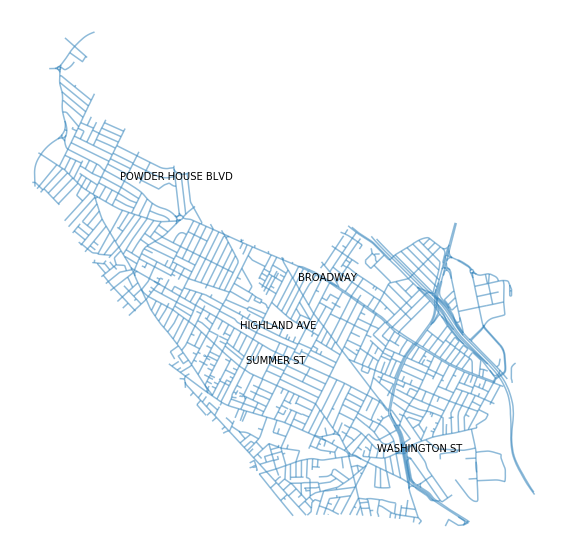

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
streets.plot(ax=ax, alpha=0.5)

for idx, row in major_streets.iterrows():
    plt.annotate(s=row['Street'], xy=row['coords']
                 #,horizontalalignment='center'
                )
    
ax.axis('off');